# Model Assesment notebook 
An example of a Model Assessment notebook. 
The notebook runs a hydrology model using [grpc4bmi](https://github.com/eWaterCycle/grpc4bmi).

In [2]:
#Import docker and set client
import docker
client = docker.from_env()
from grpc4bmi.bmi_client_docker import BmiClientDocker

In [6]:
import os
import time
import datetime
from datetime import datetime
from datetime import timedelta

import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

import hydrostats.data as hd
import hydrostats.visual as hv
import matplotlib.pyplot as plt

import HydroErr as he
from ewatercycle.parametersetdb import build_from_urls

### Setting the input and output configuration

In [ ]:
parameter_set = build_from_urls(
    config_format='ini', config_url='https://raw.githubusercontent.com/UU-Hydro/PCR-GLOBWB_input_example/master/RhineMeuse30min/ini_and_batch_files/rapid/setup_natural_test.ini',
    datafiles_format='svn', datafiles_url='https://github.com/UU-Hydro/PCR-GLOBWB_input_example/RhineMeuse30min',
)

The model inside a BMI Docker container expects the datafiles in the /data/input directory,
the config file must be adjusted to that. **Uncomment** the block of the model that you are using:

 - For **PCR-GLOBWB** model the input and output directory must be set with:

In [ ]:
parameter_set.config['globalOptions']['inputDir'] = '/data/input'
parameter_set.config['globalOptions']['outputDir'] = '/data/output'

- For **wflow** model the config file must be set with: 

In [ ]:
#parameter_set.config['model']['configfile'] = '/data/input/wflow_sbm.ini'
#replace config.cfg in the next cells with wflow_sbm.ini

- For **Walrus** model the data file must be set with

In [ ]:
#import os; parameter_set.config['data'] = '/data/input/' + os.listdir('input')[0]

Then it can be saved to the config file:

In [ ]:
parameter_set.save_config('config.cfg')

### Run docker container that contains model

In this example we use PCRGLOB

In [3]:
model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:latest', image_port=55555, 
                       input_dir="./input", 
                       output_dir="./output")

In [4]:
model.get_component_name()

'pcrglobwb'

In [5]:
#Initialize the model
%time model.initialize("config.cfg")

CPU times: user 1.61 ms, sys: 354 µs, total: 1.97 ms
Wall time: 1.08 s


In [6]:
#Retrieve the ouput variable names, these variables can be retrieved for each timestep
pcrg.get_output_var_names()

('groundwater_recharge',
 'lake_and_reservoir_storage',
 'domesticWaterConsumptionVolume',
 'land_surface_actual_evaporation',
 'groundwater_storage',
 'snow_melt',
 'totalPotentialMaximumGrossDemand',
 'interception_evaporation',
 'flood_innundation_depth',
 'total_groundwater_abstraction',
 'water_body_actual_evaporation',
 'interflow',
 'consumptive_water_use_for_irrigation_demand',
 'non_irrigation_gross_demand_volume',
 'accumulated_total_surface_runoff',
 'livestock_water_withdrawal',
 'land_surface_potential_evaporation',
 'total_groundwater_storage',
 'bare_soil_evaporation',
 'top_water_layer_evaporation',
 'transpiration_from_irrigation',
 'total_thickness_of_active_water_storage',
 'domestic_water_withdrawal',
 'netLqWaterToSoil_at_irrigation_volume',
 'interception_storage',
 'non_irrigation_gross_demand',
 'livestockWaterConsumptionVolume',
 'groundwater_depth_for_top_layer',
 'surface_water_storage',
 'irrigation_gross_demand_volume',
 'return_flow_from_irrigation_demand_

In [119]:
#Retrieve modeltimestep information
tstart = pcrg.get_start_time()
tend = pcrg.get_end_time()
tstep = pcrg.get_time_step()

tstep_nmbr = int((tend - tstart)/10) # Warning: This is dependents on how the model represents time.
print tstep_nmbr
print time.ctime(int(tstart)) + " start"
print time.ctime(int(tend)) + " end"

365
Thu Jan  1 11:08:45 1970 start
Thu Jan  1 12:09:36 1970 end


In [120]:
# I the time working is not working correctly correctly. 
# On the PCRGLOB github I do not understand why and how they get their time this way.
# For now hardcoded.

In [123]:
#Retrieve modeltimestep information
tstart = datetime(2000,1,1)
tend = datetime(2010,12,31)

tstep_nmbr = (tend-tstart).days

In [124]:
#Remove for final version
tstep_nmbr = 5

In [125]:
#Set output variable name(s) and get shape
variable = "discharge"

In [126]:
#Set correct date format that would work for all models
date_start = tstart

In [127]:
#Get lon/lat for xarray
lon = pcrg.get_grid_x(0)
lat = pcrg.get_grid_y(0)

In [128]:
#Create xarray dataset with coordinates and time series
ds = xr.Dataset(coords={'lon': lon,
                        'lat': lat,
                        'time': pd.date_range(date_start,  periods = tstep_nmbr)})
ds

<xarray.Dataset>
Dimensions:  (lat: 17, lon: 13, time: 5)
Coordinates:
  * lat      (lat) float64 3.75 4.25 4.75 5.25 5.75 ... 10.25 10.75 11.25 11.75
  * lon      (lon) float64 46.25 46.75 47.25 47.75 ... 50.75 51.25 51.75 52.25
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-05
Data variables:
    *empty*

In [129]:
#Create empty array for faster filling
data_variable = np.zeros(shape=(len(lon), len(lat),0))
data_variable.shape

(13, 17, 0)

In [130]:
#Model run with retrieval of variables for each time step

tstart = pcrg.get_start_time() # Remove after time fix

for idx, i in enumerate(range(tstep_nmbr)):
    
    pcrg.update_until(tstart + i *tstep)
    vals = pcrg.get_value(variable)
    data = numpy.reshape(vals, (len(lon), len(lat)))

    data_variable = np.dstack((data_variable, data))

In [131]:
#Append variable data to xarray dataset
ds[variable] = (('lon', 'lat', 'time'), data_variable)

<xarray.Dataset>
Dimensions:    (lat: 17, lon: 13, time: 5)
Coordinates:
  * lat        (lat) float64 3.75 4.25 4.75 5.25 ... 10.25 10.75 11.25 11.75
  * lon        (lon) float64 46.25 46.75 47.25 47.75 ... 50.75 51.25 51.75 52.25
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-05
Data variables:
    discharge  (lon, lat, time) float64 nan nan nan nan nan ... nan nan nan nan

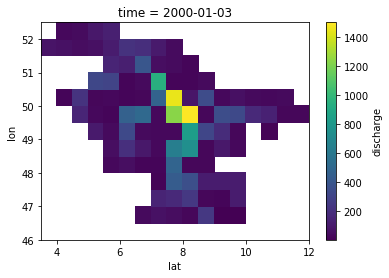

In [132]:
#Plot variable map of time step 50
array = ds[variable].isel(time= 2)
array.plot()
ds

In [161]:
def dataframe_from_stationId(grdc_folder, station_id):
    ''' Search the grdc_folder for a file with name <station_id>.day,
    skip the header rows and return the dates and discharges in a dataframe'''
    
    filename = str(station_id) + "_Q_Day.Cmd"
    grdc_file = os.path.join(grdc_folder, filename)

    grdc_data = pd.read_csv(grdc_file, skiprows=40, delimiter=';')
    
    
    
    grdc_data = grdc_data.rename(columns={grdc_data.columns[0]: 'date', grdc_data.columns[1]:'empty', grdc_data.columns[2]: 'discharge'})
    
    grdc_data = grdc_data.reset_index().set_index(pd.DatetimeIndex(grdc_data['date']))
    grdc_data = grdc_data[['date', 'discharge']]
    
    return grdc_data

In [165]:
# Import GRDC station data, set index
obs = dataframe_from_stationId('./validation/', 6435060)
obs.set_index('date', inplace=True)

In [208]:
# Select timeseries based on lat lon of GRDC station
timeseries = ds[variable].sel(lat= 8.5, lon=50.2, method= 'nearest')

sim = timeseries.to_dataframe()

In [211]:
combined = sim.merge(obs, left_index=True, right_index=True, how='inner')
combined.columns = ['lat', 'lon', 'sim', 'obs']
combined = combined.drop(columns=['lat', 'lon'])

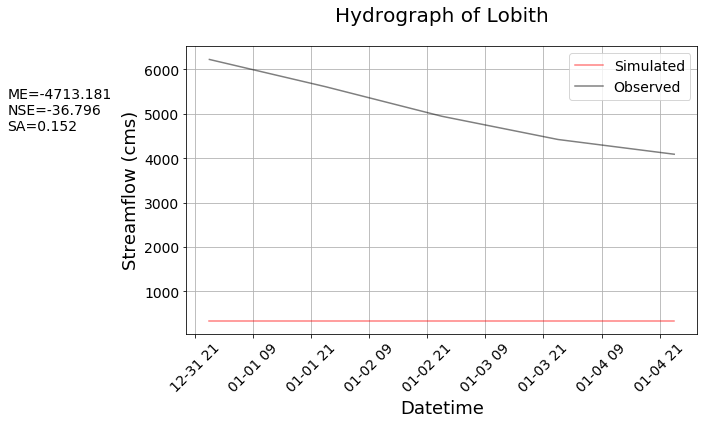

In [212]:
#Plot hydrograph for simulated and observed values and calculate statistics

hv.plot(combined,
      title='Hydrograph of Lobith',
      linestyles=['r-', 'k-'],
      legend=('Simulated', 'Observed'),
      labels=['Datetime', 'Streamflow (cms)'],
      metrics=['ME', 'NSE', 'SA'],
      grid=True)
plt.show()

In [213]:
#Write output files and close model
pcrg.finalize()

In [214]:
#Remove pcrg
del pcrg